# Chats ou chiens ? 

Par: Selim Ben Abdallah, Paola De Truchis, Eduardo De Jesus Zancanaro Garcia et Edda Iveland

In [ ]:
#Imports
#import bencodepy
#import libtorrent as lt
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

## Load data

In [4]:
torrent = bencodepy.decode_from_file('data.torrent')
info = torrent[b'info']

print("Files included:")
if b'files' in info:
    for f in info[b'files']:
        print("/".join(x.decode() for x in f[b'path']))
else:
    print(info[b'name'].decode())


Files included:
annotations.tar.gz
images.tar.gz


In [ ]:
# Run ONCE!
ses = lt.session()
ses.listen_on(6881, 6891)

info = lt.torrent_info('data.torrent')
h = ses.add_torrent({'ti': info, 'save_path': './downloaded_data'})
print(f"Downloading to: ./downloaded_data")

while not h.is_seed():
    s = h.status()
    print(f"{s.progress * 100:.2f}% complete (down: {s.download_rate/1000:.1f} kB/s)")
    time.sleep(1)

print("Download complete!")

/var/folders/xf/zsrr8nyd46x34j058kzp8gwc0000gn/T/ipykernel_75457/2676285130.py:2: DeprecationWarning: listen_on() is deprecated
  ses.listen_on(6881, 6891)
/var/folders/xf/zsrr8nyd46x34j058kzp8gwc0000gn/T/ipykernel_75457/2676285130.py:8: DeprecationWarning: is_seed() is deprecated
  while not h.is_seed():


0.00% complete (down: 0.0 kB/s)
5.43% complete (down: 0.0 kB/s)
26.61% complete (down: 0.0 kB/s)
44.70% complete (down: 0.0 kB/s)
66.93% complete (down: 0.0 kB/s)


KeyboardInterrupt: 

In [ ]:
import tarfile
#/downloaded_data/oxford-iiit-pet/annotations.tar.gz
for fname in ["./downloaded_data/oxford-iiit-pet/annotations.tar.gz", "./downloaded_data/oxford-iiit-pet/images.tar.gz"]:
    with tarfile.open(fname, "r:gz") as tar:
        tar.extractall()

/var/folders/xf/zsrr8nyd46x34j058kzp8gwc0000gn/T/ipykernel_8835/2390181455.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


## 1: analyse explorative des données 

From the readme: 
All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.

In [4]:
df = pd.read_csv(
    "./dataset/annotations/list.txt",
    sep=r"\s+",        # one or more spaces
    skiprows=6,        # skip the header/explanation lines
    header=None,       # no header row in the actual data
    names=["image", "class_id", "species", "breed_id"]
)

In [5]:
df["species_name"] = df["species"].map({1: "cat", 2: "dog"})

In [6]:
df["breed_name"] = df["image"].str.rsplit("_", n=1).str[0]

In [7]:
df.head()

image  class_id  species  breed_id species_name  breed_name
0  Abyssinian_100         1        1         1          cat  Abyssinian
1  Abyssinian_101         1        1         1          cat  Abyssinian
2  Abyssinian_102         1        1         1          cat  Abyssinian
3  Abyssinian_103         1        1         1          cat  Abyssinian
4  Abyssinian_104         1        1         1          cat  Abyssinian

### Étudier la répartition par race et par type (chat/chien),

 dog: 68%
 cat: 32%


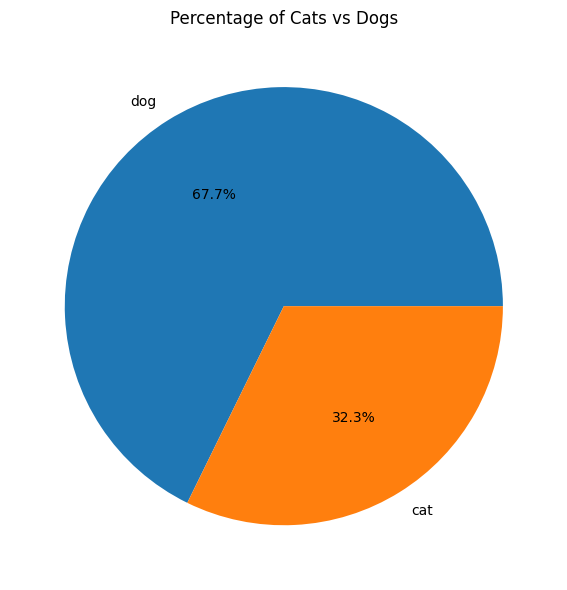

In [8]:
counts = df['species_name'].value_counts(normalize=True) * 100

for species, pct in counts.items():
    print(f" {species}: {pct:.0f}%")

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title("Percentage of Cats vs Dogs")
plt.tight_layout()
plt.show()

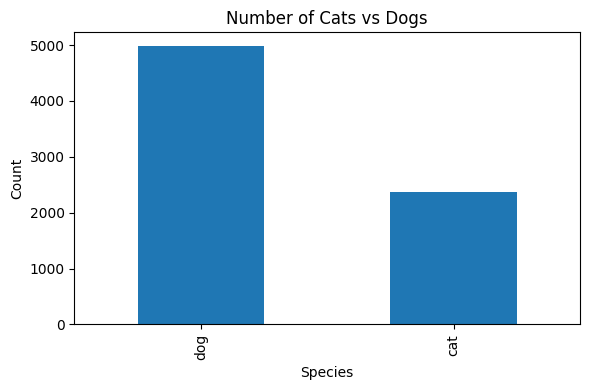

In [9]:
species_counts = df['species_name'].value_counts()
plt.figure(figsize=(6,4))
species_counts.plot(kind='bar')
plt.xlabel("Species")
plt.ylabel("Count")
plt.title("Number of Cats vs Dogs")
plt.tight_layout()
plt.show()

There are  68% images of dogs and 32% images of cats. 

In [10]:
breeds = df.groupby('species_name')['breed_id'].nunique()

for breeds, pct in breeds.items():
    print(f" There are {pct:.0f} breeds of {breeds}s")

 There are 12 breeds of cats
 There are 25 breeds of dogs


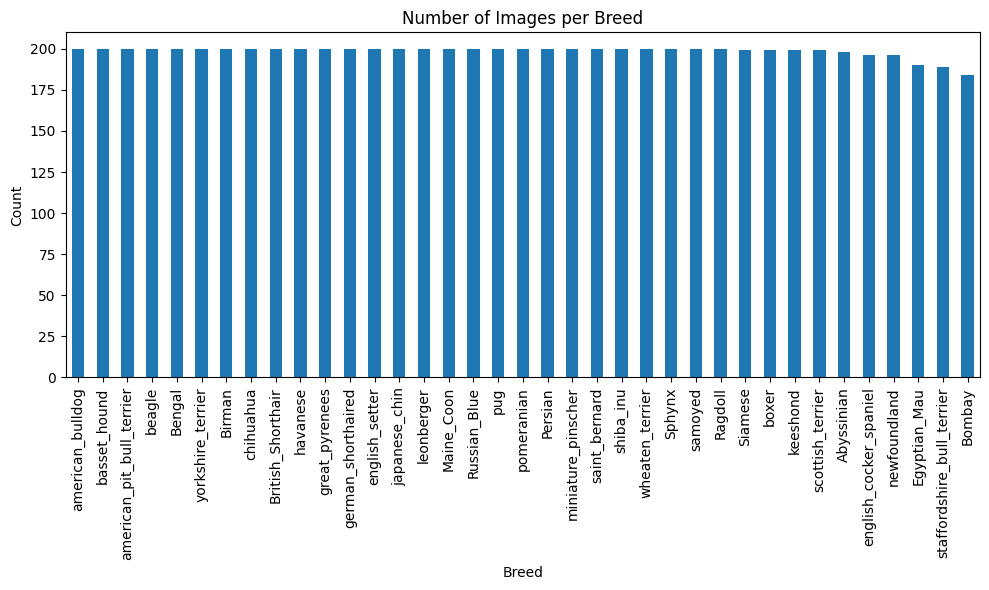

In [11]:
breed_counts = df['breed_name'].value_counts()

plt.figure(figsize=(10,6))
breed_counts.plot(kind='bar')
plt.xlabel("Breed")
plt.ylabel("Count")
plt.title("Number of Images per Breed")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

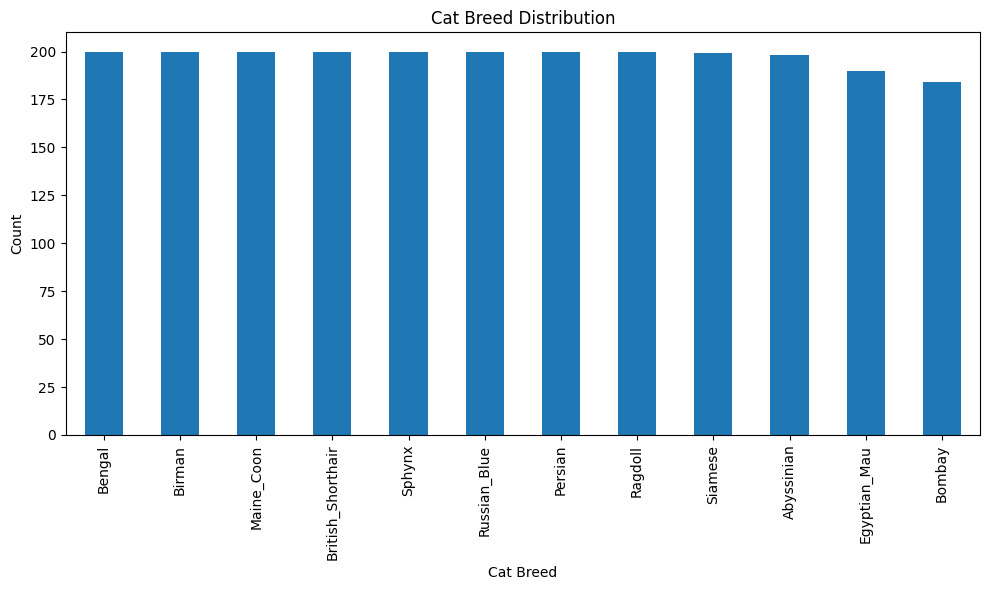

In [12]:
cat_breeds = df[df['species_name']=="cat"]["breed_name"].value_counts()

plt.figure(figsize=(10,6))
cat_breeds.plot(kind='bar')
plt.xlabel("Cat Breed")
plt.ylabel("Count")
plt.title("Cat Breed Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


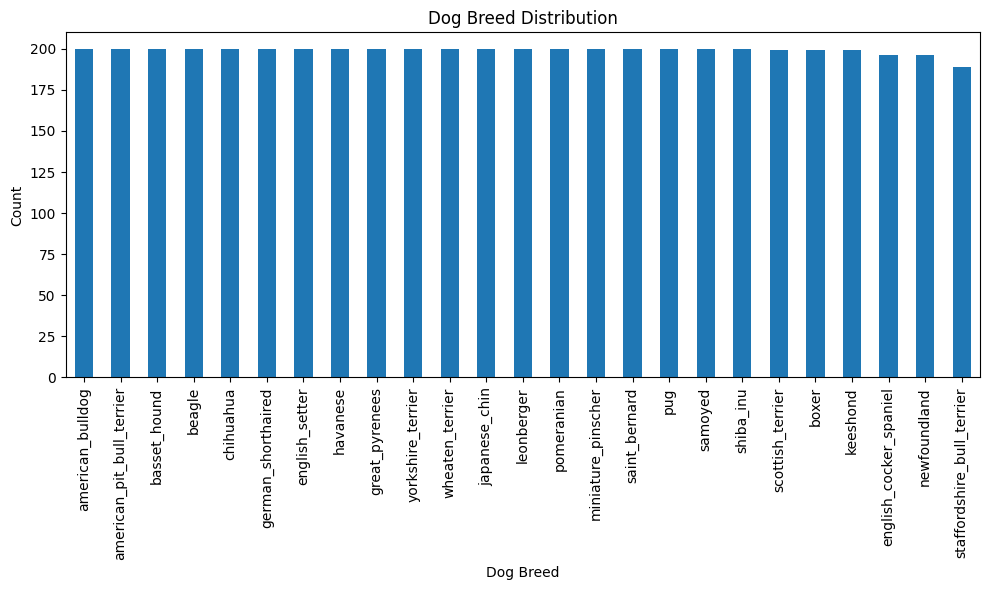

In [13]:
dog_breeds = df[df['species_name']=="dog"]["breed_name"].value_counts()

plt.figure(figsize=(10,6))
dog_breeds.plot(kind='bar')
plt.xlabel("Dog Breed")
plt.ylabel("Count")
plt.title("Dog Breed Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [14]:
images_per_breed = df['breed_name'].value_counts()

for im_per_breed, pct in images_per_breed.items():
    print(f" There are {pct:.0f} images of {im_per_breed}s")

 There are 200 images of american_bulldogs
 There are 200 images of basset_hounds
 There are 200 images of american_pit_bull_terriers
 There are 200 images of beagles
 There are 200 images of Bengals
 There are 200 images of yorkshire_terriers
 There are 200 images of Birmans
 There are 200 images of chihuahuas
 There are 200 images of British_Shorthairs
 There are 200 images of havaneses
 There are 200 images of great_pyreneess
 There are 200 images of german_shorthaireds
 There are 200 images of english_setters
 There are 200 images of japanese_chins
 There are 200 images of leonbergers
 There are 200 images of Maine_Coons
 There are 200 images of Russian_Blues
 There are 200 images of pugs
 There are 200 images of pomeranians
 There are 200 images of Persians
 There are 200 images of miniature_pinschers
 There are 200 images of saint_bernards
 There are 200 images of shiba_inus
 There are 200 images of wheaten_terriers
 There are 200 images of Sphynxs
 There are 200 images of samoye

There are more dogs than cats, and more races of dogs compared to cats. All races have 200 images each, except for : 
 - Siameses with 199 images
 - boxers with 199 images
 - keeshonds with 199 images
 - scottish_terriers with 199 images
 -  Abyssinians with 198 images
 - english_cocker_spaniels with 196 images
 - newfoundlands with 196 images
 -  Egyptian_Maus with 190 images
 - staffordshire_bull_terriers with 189 images
 - Bombays with 184 images

### Vérifier la cohérence et la qualité des masques de segmentation,

In [21]:
img_path = "dataset/images/Abyssinian_1.jpg"
mask_path = "dataset/annotations/trimaps/Abyssinian_1.png"

In [22]:
img = Image.open(img_path)
mask = Image.open(mask_path)

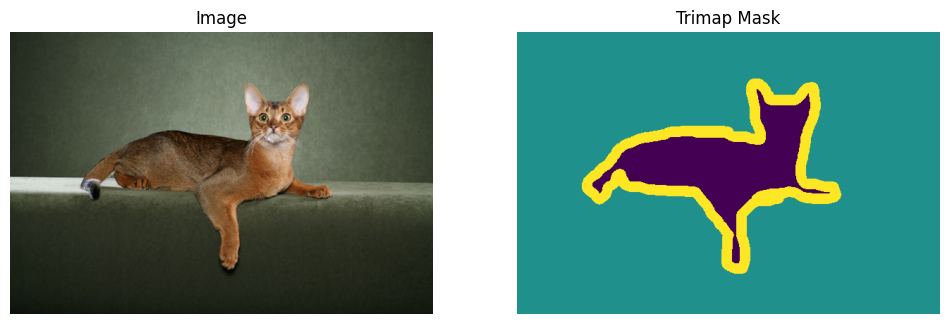

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Trimap Mask")
plt.axis("off")

plt.show()

In [24]:
if img.size == mask.size:
    print("the mask and image have the same size")

the mask and image have the same size


In [25]:
np.unique(np.array(mask))

array([1, 2, 3], dtype=uint8)

In [26]:
mask_arr = np.array(mask)
print("Foreground pixels:", np.sum(mask_arr == 1))
print("Background pixels:", np.sum(mask_arr == 2))
print("Not classified pixels:", np.sum(mask_arr == 3))

Foreground pixels: 22938
Background pixels: 198766
Not classified pixels: 18296


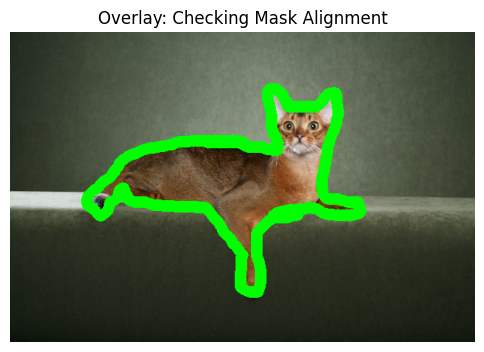

In [27]:
img_arr = np.array(img)
mask_arr = np.array(mask)

overlay = img_arr.copy() 
overlay[mask_arr == 3] = [0, 255, 0]     # green for border

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Overlay: Checking Mask Alignment")
plt.axis("off")
plt.show()


In [31]:
bad_masks = []

for file in os.listdir("dataset/annotations/trimaps"):
    mask = Image.open(os.path.join("dataset/annotations/trimaps", file))
    mask_arr = np.array(mask)

    # check valid pixel values
    if not set(np.unique(mask_arr)).issubset({1,2,3}):
        bad_masks.append(file)

In [32]:
if bad_masks == []: 
    print("All pixel masks are good")

All pixel masks are good


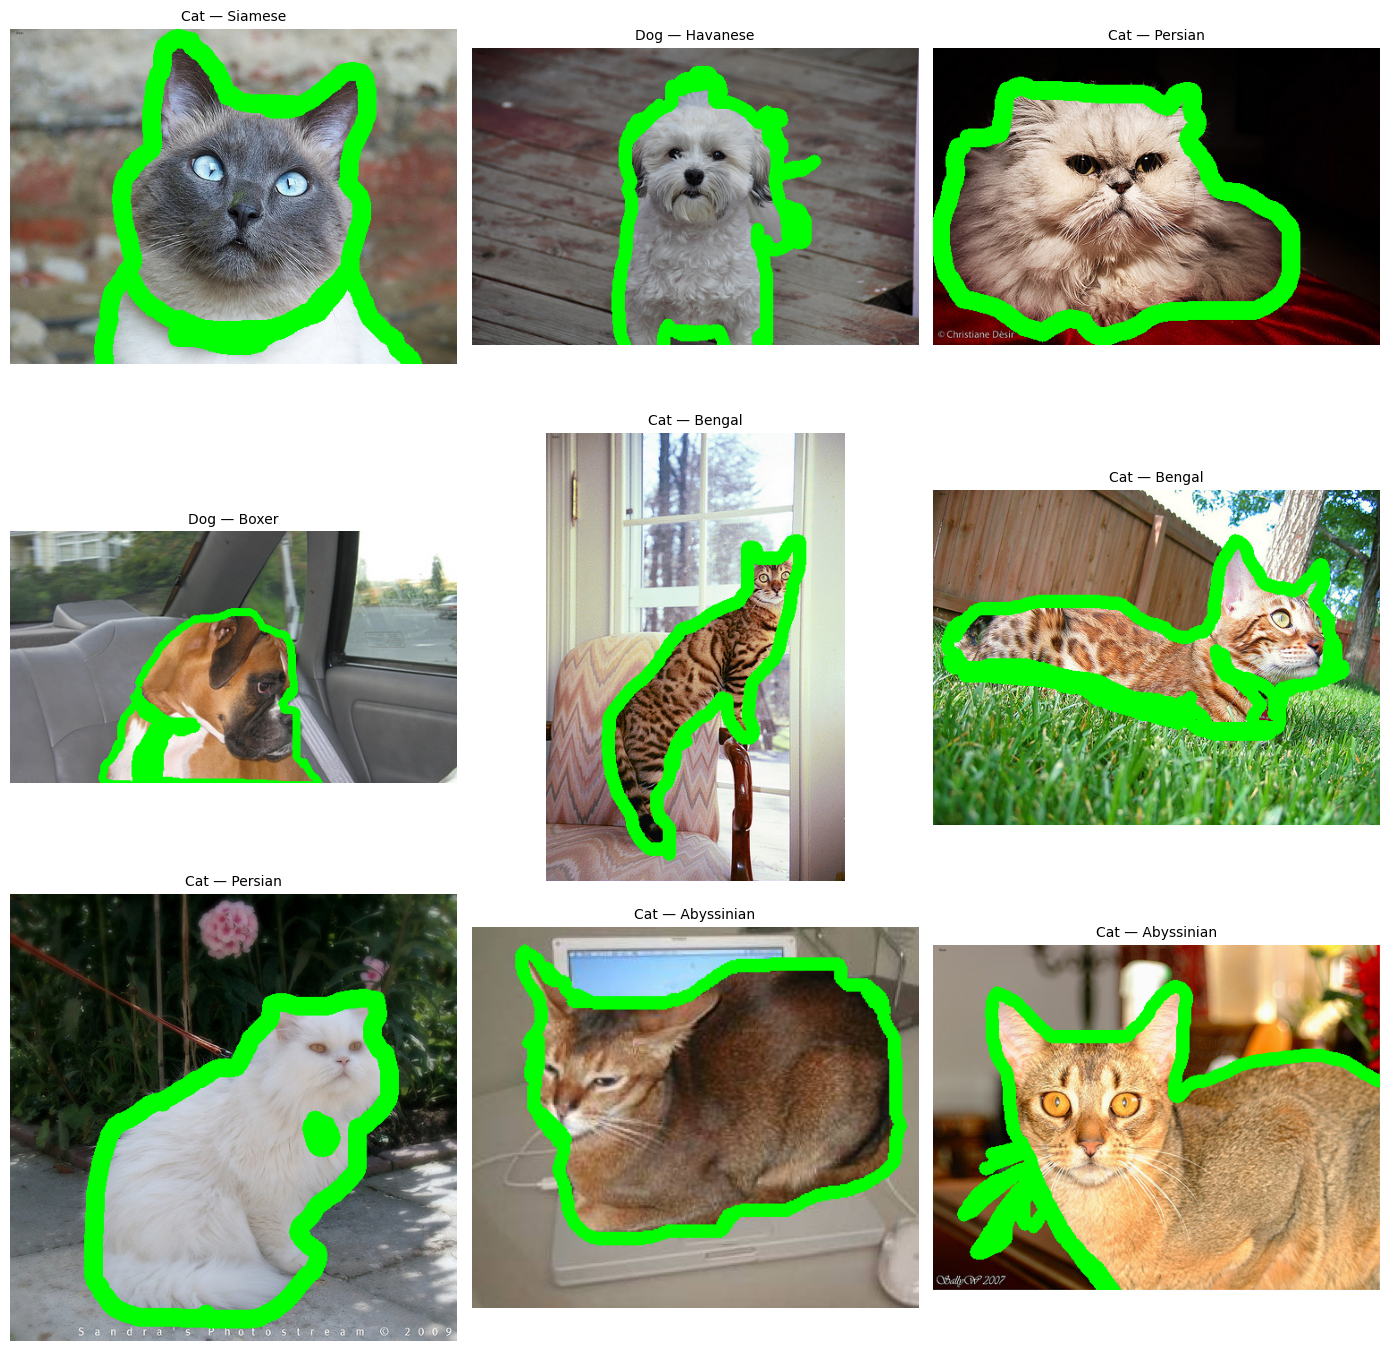

In [35]:
# Showing masking of random images

image_dir = "dataset/images"
mask_dir = "dataset/annotations/trimaps"

# Filter out MacOS ghost files
mask_files = [
    f for f in os.listdir(mask_dir)
    if f.endswith(".png") and not f.startswith("._")
]

# Choose 9 random mask files
sample_masks = random.sample(mask_files, 9)

plt.figure(figsize=(14, 14))

for i, mask_file in enumerate(sample_masks, 1):
    
    # matching image filename
    img_file = mask_file.replace(".png", ".jpg")

    # --- Load image and mask ---
    img = Image.open(os.path.join(image_dir, img_file))
    mask = Image.open(os.path.join(mask_dir, mask_file))

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # Overlay 
    overlay = img_arr.copy()
    overlay[mask_arr == 3] = [0, 255, 0]    # green outline

    # Extract metadata from dataframe 
    # remove ".jpg" for merging with df's image column
    image_id = img_file.replace(".jpg", "")
    
    row = df[df["image"] == image_id].iloc[0]
    
    species = row["species_name"].capitalize()       # Cat / Dog
    breed = row["breed_name"].replace("_", " ").title()   # Pretty formatting

    title = f"{species} — {breed}"

    # --- Plot ---
    plt.subplot(3, 3, i)
    plt.imshow(overlay)
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


###  Identifier d’éventuels déséquilibres ou biais visuels

- The images of dogs tend to be outside, whereas cats are mostly inside, this could lead to an illigitemate false discrimination criteria

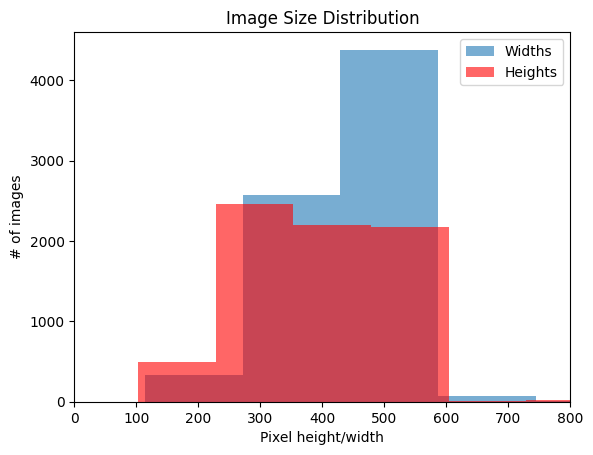

In [38]:
# Checking image size difference

widths = []
heights = []

for img_file in os.listdir("dataset/images"):
    if img_file.startswith("._") or img_file.endswith(".mat"):
        continue
    img = Image.open(os.path.join("dataset/images", img_file))
    w, h = img.size
    widths.append(w)
    heights.append(h)

plt.hist(widths, bins=20, label= "Widths", alpha= 0.6)
plt.hist(heights, bins=20, color = "red", label = "Heights", alpha= 0.6)
plt.title("Image Size Distribution")
plt.xlabel("Pixel height/width")
plt.ylabel("# of images")
plt.legend()
plt.xlim(0, 800)
plt.show()

Background bias: 

Some breeds might always be photographed:

indoors, outdoors, on grass, on sofa, with specific lighting

Simplest proxy: average color.

In [40]:
df["avg_brightness"] = df["image"].apply(lambda name:
    np.array(Image.open(f"dataset/images/{name}.jpg")).mean()
)
df.groupby("species_name")["avg_brightness"].mean()
df.groupby("breed_name")["avg_brightness"].mean()

breed_name
Abyssinian                    108.387171
Bengal                        114.956613
Birman                        115.413828
Bombay                        102.787585
British_Shorthair             116.221129
Egyptian_Mau                  112.152623
Maine_Coon                    104.059740
Persian                       117.795278
Ragdoll                       121.984063
Russian_Blue                  120.373281
Siamese                       114.449629
Sphynx                        107.955515
american_bulldog              106.807213
american_pit_bull_terrier     108.714921
basset_hound                  104.943276
beagle                        104.149750
boxer                         113.435484
chihuahua                     113.203071
english_cocker_spaniel        114.961220
english_setter                107.423808
german_shorthaired            115.803286
great_pyrenees                109.441567
havanese                      113.606674
japanese_chin                 103.077990
keesh

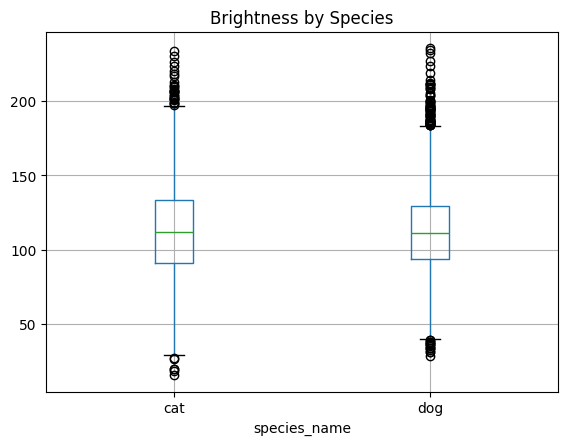

In [41]:
df.boxplot(column="avg_brightness", by="species_name")
plt.title("Brightness by Species")
plt.suptitle("")
plt.show()

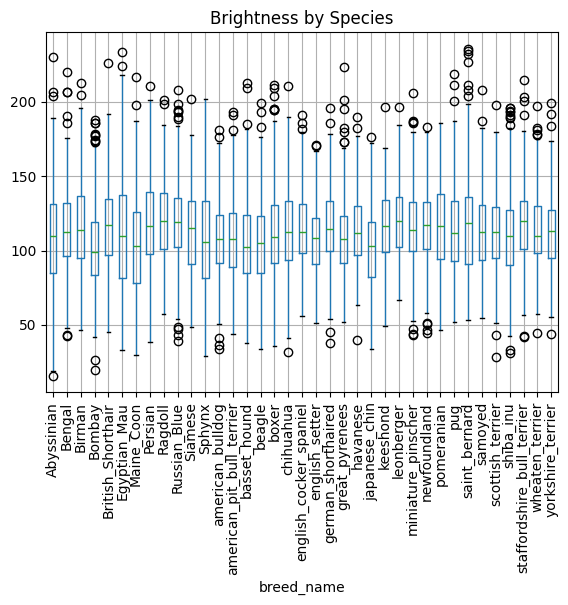

In [ ]:
df.boxplot(column="avg_brightness", by="breed_name")
plt.title("Brightness by Species")
plt.xticks(rotation=90)
plt.suptitle("")
plt.show()

In [43]:
def average_green_level(image_name):
    img_path = f"dataset/images/{image_name}.jpg"
    img = np.array(Image.open(img_path))
    return img[:, :, 1].mean()     # channel 1 = green

In [44]:
df["avg_green"] = df["image"].apply(average_green_level)
df.groupby("species_name")["avg_green"].mean()
df.groupby("breed_name")["avg_green"].mean().sort_values(ascending=False)

breed_name
staffordshire_bull_terrier    124.534466
leonberger                    124.301299
saint_bernard                 122.561015
Russian_Blue                  121.787142
german_shorthaired            121.544340
Ragdoll                       121.239719
newfoundland                  120.713787
keeshond                      120.222389
english_cocker_spaniel        117.913686
pomeranian                    117.814057
miniature_pinscher            117.626529
Persian                       117.620032
samoyed                       117.070468
havanese                      116.878597
Birman                        116.589376
Bengal                        116.423546
wheaten_terrier               115.833089
British_Shorthair             115.768101
scottish_terrier              115.114415
Siamese                       115.019414
shiba_inu                     114.324120
pug                           114.306345
boxer                         113.567200
yorkshire_terrier             113.559886
great

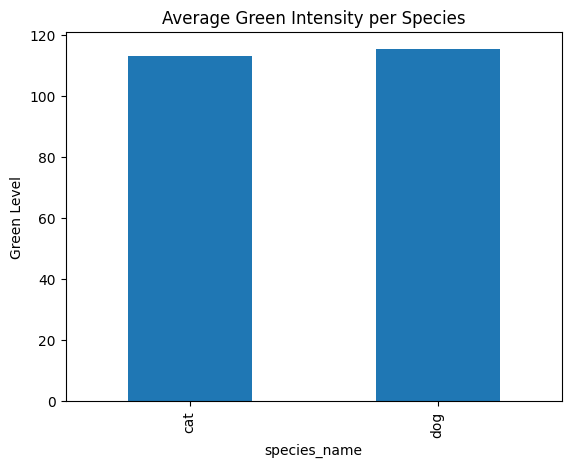

In [45]:
df.groupby("species_name")["avg_green"].mean().plot(kind="bar")
plt.title("Average Green Intensity per Species")
plt.ylabel("Green Level")
plt.show()

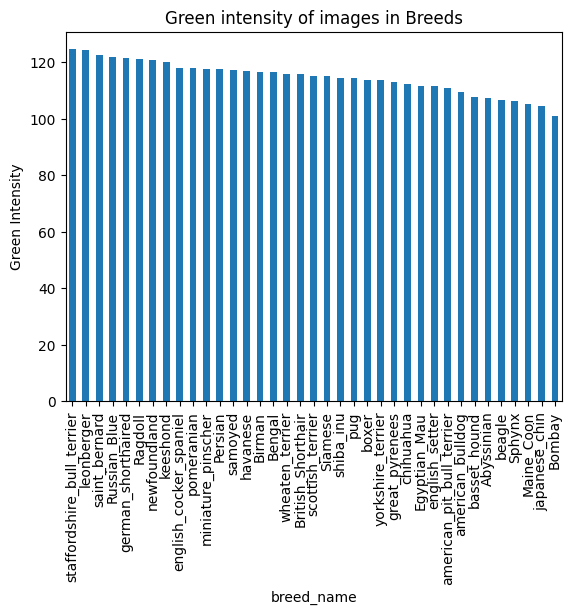

In [46]:
df.groupby("breed_name")["avg_green"].mean().nlargest(37).plot(kind="bar")
plt.title("Green intensity of images in Breeds")
plt.ylabel("Green Intensity")
plt.show()

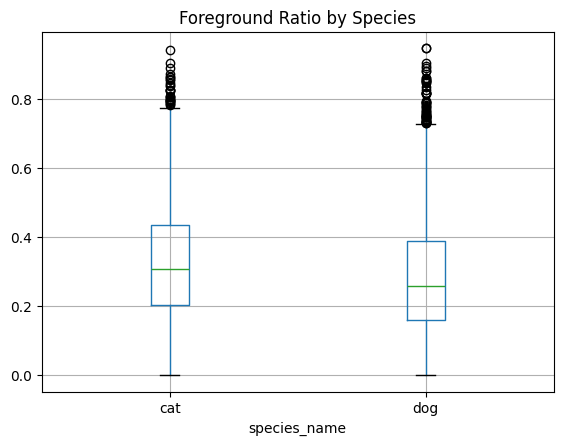

In [48]:
# Segmentation mask bias
foreground_ratios = []

for _, row in df.iterrows():
    mask_file = f"{row['image']}.png"
    mask = np.array(Image.open(f"dataset/annotations/trimaps/{mask_file}"))
    fg_ratio = (mask == 1).mean()
    foreground_ratios.append(fg_ratio)

df["fg_ratio"] = foreground_ratios

df.boxplot(column="fg_ratio", by="species_name")
plt.title("Foreground Ratio by Species")
plt.suptitle("")
plt.show()

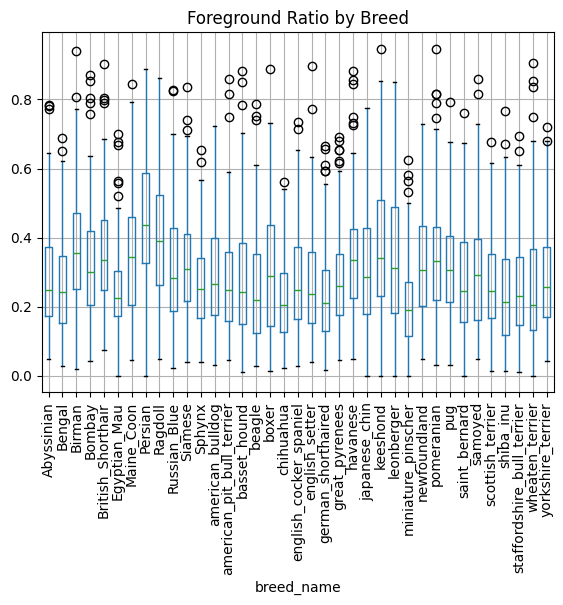

In [49]:
df.boxplot(column="fg_ratio", by="breed_name")
plt.title("Foreground Ratio by Breed")
plt.suptitle("")
plt.xticks(rotation=90)
plt.show()

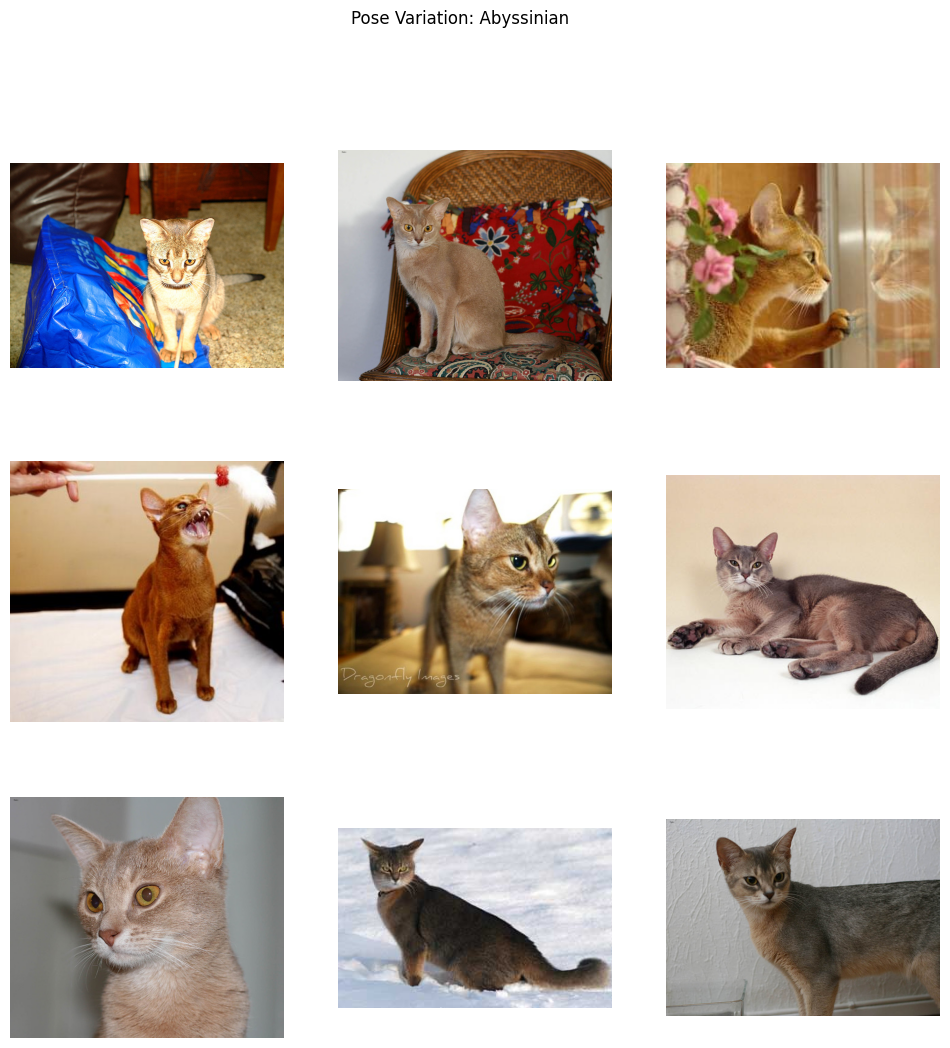

In [50]:
# Pose bias

breed = "Abyssinian"   # try with any breed

sample = df[df["breed_name"] == breed].sample(9)

plt.figure(figsize=(12, 12))
for i, (_, row) in enumerate(sample.iterrows(), 1):
    img = Image.open(f"dataset/images/{row['image']}.jpg")
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle(f"Pose Variation: {breed.title()}")
plt.show()

Conclusion of the first part: 



### TrainVal / Test Datasets

In [3]:
def load_split_file(path, img_root, mask_root):
    rows = []

    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()

            class_id = parts[0]           # Abyssinian_100
            id_      = int(parts[1])      # 1–37 (class id)
            species  = int(parts[2])      # 1=cat, 2=dog
            breed_id = int(parts[3])      # 1–25 cat, 1–12 dog
            specie_name = "_".join(class_id.split("_")[:-1])

            rows.append({
                "class_id": class_id,
                "id": id_,
                "species": species,
                "breed_id": breed_id,
                "species_name": specie_name,
                "img_path": f"{img_root}/{class_id}.jpg",
                "trimap_path": f"{mask_root}/{class_id}.png",
            })

    return pd.DataFrame(rows)

In [4]:
trainval_df = load_split_file(
    "dataset/annotations/trainval.txt",
    img_root="dataset/images",
    mask_root="dataset/annotations/trimaps"
)

test_df = load_split_file(
    "dataset/annotations/test.txt",
    img_root="dataset/images",
    mask_root="dataset/annotations/trimaps"
)

In [5]:
# Multiclass label
trainval_df["label"] = trainval_df["id"]  # 1=Abyssinian, etc..
test_df["label"] = test_df["id"]

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df["label"],
    random_state=42,
)

In [8]:
PATH_TO_TRAINVAL_TXT = "dataset/annotations/trainval.txt"
PATH_TO_TEST_TXT = "dataset/annotations/test.txt"
PATH_TO_LIST_TXT = "dataset/annotations/list.txt"

PATH_TO_IMG = "dataset/images/" # .jpg
PATH_TO_TRIMAPS = "dataset/annotations/trimaps/" #.png

In [9]:
import torchvision.transforms as T

In [10]:
pixel_size = (128,128)
mean_RGB = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
train_transform = T.Compose([
    T.Resize(pixel_size),
    T.RandomHorizontalFlip(p=0.5), #basic augm 
    T.ToTensor(),
    T.Normalize(mean = mean_RGB,
                std = std_rgb),
])

val_transform = T.Compose([
    T.Resize(pixel_size),
    T.ToTensor(),
    T.Normalize(mean = mean_RGB,
                std = std_rgb),
])

## 2. Classification binaire : distinguer les chats des chiens à partir de leur photo uniquement.

Idées: CNNs

In [11]:
# Step 1: seperate dogs and cats

# Split data into train, test and validation sets

#Creation of lists containing the image names of the training, validation and test sets, as well as the associated labels

#Creation of dataframes to enable data to be loaded as required.


In [12]:
# Step 2: Do we need to impose a common image size? 


In [13]:
# Step 3: Train basic convolutional neural network


#Measure  % of correct classif on test set

In [14]:
#Step 4: Data augmentation to fix dropout



Conclustion on the second part. 

## 3. Classification fine : reconnaître la race de chaque animal parmi les 37 catégories disponibles.

Idees: 

TP MNIST, multiclass clasification: 
- Optimizer: RMSprop
- loss function: Categorical crossentropy

Use confustioin matrix from sklearn

In [15]:
from torch.utils.data import Dataset


class PetsClassificationDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = Image.open(row["img_path"]).convert("RGB")
        label = int(row["label"])  # 1=Abyssinian, etc..

        if self.transform:
            img = self.transform(img)

        return img, label

In [16]:
from torch.utils.data import DataLoader

train_ds = PetsClassificationDataset(train_df, transform=train_transform)
val_ds   = PetsClassificationDataset(val_df,   transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

In [17]:
N_train = len(train_df)
N_test = len(val_df)
N_x_pixels = pixel_size[0]
N_y_pixels = pixel_size[1]
N_channels = len(std_rgb)
N_classes = train_df["label"].nunique()
N_dim_flatten = N_channels*N_x_pixels*N_y_pixels
print(N_classes)
print(N_channels,N_x_pixels, N_y_pixels)
print("Train size:", N_train)
print("Val size:", N_test)

37
3 128 128
Train size: 2944
Val size: 736


### Network definition

CNN model

In [18]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

Using device: cpu


In [19]:
from torch.optim import RMSprop, Adadelta

In [35]:
for _, labels in train_loader:
    print(labels.max(), labels.min())
    break

tensor(35) tensor(1)


In [30]:
# Define CNN

class ConvNet(nn.Module):
    def __init__(self, N_classes):
        super(ConvNet, self).__init__()
        # input shape: (batch, 3, 128, 128)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64*62*62, 128)  # after conv/pool layers
        self.fc2 = nn.Linear(128, N_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))       # Conv + ReLU
        x = F.relu(self.conv2(x))       # Conv + ReLU
        x = self.pool(x)                # MaxPooling
        x = self.dropout1(x)            # Dropout 0.25
        x = torch.flatten(x, 1)         # Flatten from (B, C, H, W) -> (B, C*H*W)
        x = F.relu(self.fc1(x))         # Dense 128 + ReLU
        x = self.dropout2(x)            # Dropout 0.5
        x = self.fc2(x)                 # Output layer (raw logits)
        return x                        # logits; use CrossEntropyLoss

# Instantiate model
model_multiclass = ConvNet(N_classes).to(device)

# Print model summary
print(model_multiclass)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=246016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=37, bias=True)
)


In [31]:
criterion = nn.CrossEntropyLoss()          # combines LogSoftmax + NLLLoss
optimizer = Adadelta(model_multiclass.parameters())

In [32]:
from tqdm import tqdm

In [33]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [34]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(2):
    train_loss, train_acc = train_one_epoch(model_multiclass, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_multiclass, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

IndexError: Target 37 is out of bounds.

Conclustion on the third part. 

## 4. Segmentation des animaux

### 4.1. Implémenter un réseau de type U-Net from scratch pour segmenter les animaux

### 4.2 Évaluer la qualité de segmentation avec des métriques adaptées (IoU, Dice score, etc.)

Conclustion on the fourth part. 

## 5. Analyse comparative

### 5.1 Comparer les performances de segmentation selon les races

### 5.1 Analyser les différences de comportement entre chats et chiens

Conclustion on the fifth part. 

## Conclusion